In [15]:
import pandas as pd
import numpy as np

from keras import Input
from keras.engine import Model
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import Concatenate, concatenate, TimeDistributed, Flatten
from keras.callbacks import TensorBoard

In [16]:

# features is a list of strings of feature names 

def build_model(features, data_length):
    
    inputs_list = [] 
    for feature_name in features:
        inputs_list.append((Input(shape=(data_length,1), name=feature_name)))
    
    layers = [] 
    for i, input_name in enumerate(inputs_list): 
        layers.append(LSTM(16, return_sequences=True)(inputs_list[i]) )
        
    merged = concatenate(layers) 
    
    #main_output = Dense(32, activation='relu')(output)
    
    #output = TimeDistributed(Dense(3, activation='softmax', name='IsSpike'))(output)
    
    hidden1 = TimeDistributed(Dense(16, activation='relu'))(merged)
    
    flattened = Flatten()(hidden1) 
    
    output = Dense(1, activation='relu', name='price')(flattened)
    
    
    model = Model(
        inputs = inputs_list,
        outputs = [output]
    )
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
    
    return model    

data_length = 24


In [17]:
from sklearn.preprocessing import MinMaxScaler

master_df = pd.read_csv('C:/Users/Shoya/surf/data/master_df_v3.csv', encoding='latin1')
df = master_df[['Timestamp', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Date(UTC)', 'Bitcoin (Adj.Overlap)', 
               'Close Price % Change', 'Close Price % Change (Abs)', 'Is Spike']]


trends_df = pd.read_csv('C:/Users/Shoya/surf/data/Adj_Google_Trends_for_Mult_Keywords.csv', encoding='latin1') 
trends_cols = ["BitstampTrend", "CoinbaseTrend", "EthereumTrend", "BubbleTrend", "CryptocurrencyTrend", 
               "HashingTrend", "BlockchainTrend" ]


# lag inputs depending on data_length 
df['Price_lagged'] = df['Close']#.shift(data_length)
df['Volume_BTC'] = df['Volume_(BTC)']#.shift(data_length)
df['Bitcoin_Adj'] = df['Bitcoin (Adj.Overlap)']#.shift(data_length)

df[trends_cols] = trends_df[trends_cols]

df = df.dropna()


#cols = ['Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged']
cols = [
 'Volume_BTC','Bitcoin_Adj', 'Close', 'Price_lagged',
 "BitstampTrend", "CoinbaseTrend", "BubbleTrend", "CryptocurrencyTrend", 
    "HashingTrend", "BlockchainTrend"    
]


# Stationalize Data by taking log differences
data_array = np.diff(np.log(df[cols]), axis=0)
df_2 = pd.DataFrame(data_array, columns=cols)
df_scaled = df_2.replace([np.inf, -np.inf], np.nan).dropna()
# Min-Max Scale 

scalers = {}
datas = [] 

#df_scaled = pd.DataFrame(columns=cols)


############################################################
#  Fix below - I am scaling the whole data set together, when I should scale the train and test datasets separately
############################################################

for i in range(len(cols)): 
    scalers[cols[i]] = MinMaxScaler()
    #print('data', data_array[:,i])
    
    col_data = data_array[:,i]
    
    col_data = pd.Series(col_data).replace([np.inf, -np.inf], np.nan).dropna().values
    
    col_data = np.reshape(col_data, (len(col_data), 1))
    
    data = scalers[cols[i]].fit_transform( col_data )
    #print('scaled', data)
    data = np.reshape(data, (1, len(data)))
    df_scaled[cols[i]] = pd.Series(data[0])

df_scaled['Is Spike'] = df['Is Spike']
df_scaled.dropna(inplace=True)
display(df_scaled.head())
display(df_scaled.tail())

C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Shoya\Anaconda2\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.py

,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,BitstampTrend,CoinbaseTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend,Is Spike
1,0.776791,0.471970,0.484557,0.484557,0.526899,0.605058,0.535584,0.527141,0.333716,0.576911,1.0
2,0.463316,0.439996,0.538331,0.538331,0.524515,0.551960,0.512201,0.501026,0.395838,0.520447,1.0
3,0.725079,0.529463,0.520715,0.520715,0.503101,0.578359,0.574125,0.500021,0.328380,0.515816,-1.0
4,0.210661,0.416611,0.566098,0.566098,0.481687,0.550792,0.535584,0.490725,0.401071,0.545998,0.0
5,0.594148,0.445509,0.568881,0.568881,0.503101,0.610758,0.535584,0.652792,0.284584,0.438642,-1.0


,Volume_BTC,Bitcoin_Adj,Close,Price_lagged,BitstampTrend,CoinbaseTrend,BubbleTrend,CryptocurrencyTrend,HashingTrend,BlockchainTrend,Is Spike
30197,0.511200,0.435052,0.528579,0.528579,0.498689,0.527715,0.473545,0.509784,0.371092,0.526187,-1.0
30198,0.478128,0.426471,0.560737,0.560737,0.498596,0.554062,0.519161,0.518383,0.375046,0.525074,-1.0
30199,0.496631,0.427146,0.526134,0.526134,0.451915,0.552787,0.483831,0.518284,0.261137,0.524087,1.0
30200,0.613268,0.453625,0.516569,0.516569,0.401379,0.572967,0.517432,0.509883,0.379883,0.473249,-1.0
30201,0.443013,0.453625,0.582366,0.582366,0.493590,0.599583,0.487998,0.514084,0.282666,0.536255,1.0


In [24]:
from keras.utils.np_utils import to_categorical

# split and reshape data to feed into RNN

# for some reason, the more elegant dict approach on v2 notebook doesn't work so I will do this longer version

X_volume = df_scaled['Volume_BTC'].values
X_trends = df_scaled['Bitcoin_Adj'].values
X_lagged_price = df_scaled['Price_lagged'].values
X_trends_coinbase = df_scaled["CoinbaseTrend"].values
X_trends_blockchain = df_scaled["BlockchainTrend"].values
X_trends_bubble = df_scaled["BubbleTrend"].values


# train_size = int(len(X_volume) * 0.80)
# train_size = int(train_size/data_length) * data_length

test_size_index = int(len(X_volume)/data_length)*data_length

train_size = int(len(X_volume) * 0.80)
train_size = int(train_size/data_length) * data_length

X_train_volume = []
X_test_volume = [] 
X_train_trends = []
X_test_trends = []
X_train_trends_coinbase = [] 
X_test_trends_coinbase = [] 
X_train_trends_blockchain = []
X_test_trends_blockchain = []
X_train_trends_bubble = []
X_test_trends_bubble = []
X_train_lagged_price = []
X_test_lagged_price = []

Y_train_price = [] 
Y_test_price = [] 


for i in range(train_size-data_length):
    vol_temp = []
    trends_temp = []
    lagged_price_temp = []
    trends_coinbase_temp = [] 
    trends_blockchain_temp = []
    trends_bubble_temp = []
    price_temp = [] 
    for j in range(data_length):
        vol_temp.append(X_volume[i+j])
        trends_temp.append(X_trends[i+j])
        lagged_price_temp.append(X_lagged_price[i+j])
        trends_coinbase_temp.append(X_trends_coinbase[i+j])
        trends_blockchain_temp.append(X_trends_blockchain[i+j])
        trends_bubble_temp.append(X_trends_bubble[i+j])
    X_train_volume.append(vol_temp)
    X_train_trends.append(trends_temp)
    X_train_lagged_price.append(lagged_price_temp)
    X_train_trends_coinbase.append(trends_coinbase_temp)
    X_train_trends_blockchain.append(trends_blockchain_temp)
    X_train_trends_bubble.append(trends_bubble_temp)
    
    Y_train_price.append(X_lagged_price[i+data_length])
    
for i in range(test_size_index-train_size-data_length):
    vol_temp = []
    trends_temp = [] 
    lagged_price_temp = [] 
    trends_coinbase_temp = [] 
    trends_blockchain_temp = []
    trends_bubble_temp = []
    price_temp = [] 
    for j in range(data_length):
        vol_temp.append(X_volume[train_size+i+j])
        trends_temp.append(X_trends[train_size+i+j])
        lagged_price_temp.append(X_lagged_price[train_size+i+j])
        trends_coinbase_temp.append(X_trends_coinbase[train_size+i+j])
        trends_blockchain_temp.append(X_trends_blockchain[train_size+i+j])
        trends_bubble_temp.append(X_trends_bubble[train_size+i+j])
    X_test_volume.append(vol_temp)
    X_test_trends.append(trends_temp)
    X_test_lagged_price.append(lagged_price_temp)
    X_test_trends_coinbase.append(trends_coinbase_temp)
    X_test_trends_blockchain.append(trends_blockchain_temp)
    X_test_trends_bubble.append(trends_bubble_temp)
    
    Y_test_price.append(X_lagged_price[train_size+i+data_length])
    
X_train_volume = np.array(X_train_volume)
X_test_volume =  np.array(X_test_volume)
X_train_trends = np.array(X_train_trends)
X_test_trends = np.array(X_test_trends)
X_train_trends_coinbase = np.array(X_train_trends_coinbase)
X_test_trends_coinbase = np.array(X_test_trends_coinbase)
X_train_lagged_price = np.array(X_train_lagged_price)
X_test_lagged_price = np.array(X_test_lagged_price)
X_train_trends_blockchain = np.array(X_train_trends_blockchain)
X_test_trends_blockchain = np.array(X_test_trends_blockchain)
X_train_trends_bubble = np.array(X_train_trends_bubble)
X_test_trends_bubble = np.array(X_test_trends_bubble)

Y_train_price =  np.array(Y_train_price)
Y_test_price = np.array(Y_test_price)
    
    
# Y_train_is_spike_onehot = to_categorical(Y_train_is_spike, num_classes=3)
# Y_test_is_spike_onehot = to_categorical(Y_test_is_spike,num_classes=3)



X_train_volume = np.reshape(X_train_volume, (X_train_volume.shape[0],data_length,1) ) 
X_train_trends = np.reshape(X_train_trends, (X_train_trends.shape[0],data_length,1) ) 
X_train_trends_coinbase = np.reshape(X_train_trends_coinbase, (X_train_trends_coinbase.shape[0],data_length,1) ) 
X_train_lagged_price = np.reshape(X_train_lagged_price, (X_train_lagged_price.shape[0], data_length, 1))
X_train_trends_blockchain = np.reshape(X_train_trends_blockchain, (X_train_trends_blockchain.shape[0],data_length,1) )
X_train_trends_bubble = np.reshape(X_train_trends_bubble, (X_train_trends_bubble.shape[0],data_length,1) )

X_test_volume = np.reshape(X_test_volume, (X_test_volume.shape[0],data_length,1) ) 
X_test_trends = np.reshape(X_test_trends, (X_test_trends.shape[0],data_length,1) )  
X_test_trends_coinbase = np.reshape(X_test_trends_coinbase, (X_test_trends_coinbase.shape[0],data_length,1) )  
X_test_lagged_price = np.reshape(X_test_lagged_price, (X_test_lagged_price.shape[0],data_length,1))
X_test_trends_blockchain = np.reshape(X_test_trends_blockchain, (X_test_trends_blockchain.shape[0],data_length,1) )
X_test_trends_bubble = np.reshape(X_test_trends_bubble, (X_test_trends_bubble.shape[0],data_length,1) )

In [21]:
#features = ['Volume_BTC', 'Price_lagged', 'CoinbaseTrend']
#features = ['Volume_BTC', 'Bitcoin_Adj', 'Price_lagged']
#features = ['Volume_BTC', 'Price_lagged']
key_features = [
    'Volume_BTC',
    'Bitcoin_Adj', 
    'Price_lagged', 
    'CoinbaseTrend',
    'BlockchainTrend',
    'BubbleTrend'
]
rnn = build_model(key_features, data_length) 

tensorboard_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

history = rnn.fit(
    [
        X_train_volume,
        X_train_trends,
        X_train_lagged_price,
        X_train_trends_coinbase,
        X_train_trends_blockchain,
        X_train_trends_bubble
    ],
    [
        Y_train_price
    ]
    ,
#     validation_data=(
#         [
#             X_test_volume,
#             X_test_trends,
#             X_test_lagged_price,
#             X_test_trends_coinbase,
#             X_test_trends_blockchain,
#             X_test_trends_bubble
#         ],
#         [
#             Y_test_price
#         ]),
    epochs=10,
    batch_size=64,
    callbacks=[
      tensorboard_callback
    ],
    verbose=1
)

Epoch 1/10
24048/24048 [==============================] - 55s - loss: 0.0023 - mean_squared_error: 0.0023    
Epoch 2/10
24048/24048 [==============================] - 54s - loss: 0.0014 - mean_squared_error: 0.0014    
Epoch 3/10
24048/24048 [==============================] - 54s - loss: 0.0013 - mean_squared_error: 0.0013    
Epoch 4/10
24048/24048 [==============================] - 54s - loss: 0.0012 - mean_squared_error: 0.0012    
Epoch 5/10
24048/24048 [==============================] - 54s - loss: 0.0011 - mean_squared_error: 0.0011    
Epoch 6/10
24048/24048 [==============================] - 54s - loss: 0.0010 - mean_squared_error: 0.0010    
Epoch 7/10
24048/24048 [==============================] - 54s - loss: 9.8719e-04 - mean_squared_error: 9.8719e-04    
Epoch 8/10
24048/24048 [==============================] - 54s - loss: 9.7251e-04 - mean_squared_error: 9.7251e-04    
Epoch 9/10
24048/24048 [==============================] - 54s - loss: 9.5705e-04 - mean_squared_error: 9

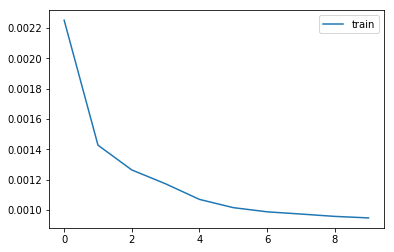

In [22]:
from matplotlib import pyplot as plt

# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [25]:
score = rnn.evaluate(
    [
        X_test_volume,
        X_test_trends,
        X_test_lagged_price,
        X_test_trends_coinbase,
        X_test_trends_blockchain,
        X_test_trends_bubble
    ],
    [
        Y_test_price
    ])


display(score)

5984/6000 [============================>.] - ETA: 0s

[0.0024107937139148513, 0.0024107937139148513]

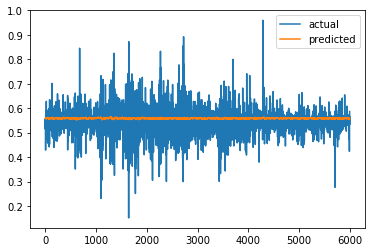

array([[ 0.55891812],
       [ 0.55905968],
       [ 0.55951738],
       ..., 
       [ 0.55794108],
       [ 0.5581879 ],
       [ 0.55725044]], dtype=float32)

(6000, 1)

(6000, 1)

array([[ 0.55891812],
       [ 0.55905968],
       [ 0.55951738],
       ..., 
       [ 0.55794108],
       [ 0.5581879 ],
       [ 0.55725044]], dtype=float32)

array([[ 0.00384966],
       [ 0.00388827],
       [ 0.00401311],
       ..., 
       [ 0.00358316],
       [ 0.00365049],
       [ 0.00339479]], dtype=float32)

'yhat_inverted'

array([  1.00385714e+00,   1.00776792e+00,   1.01182032e+00, ...,
         6.05778790e+09,   6.07994317e+09,   6.10062029e+09], dtype=float32)

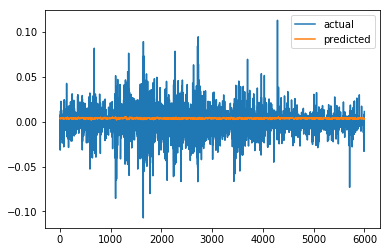

array([ 1.00217111,  0.99407598,  0.98906003, ...,  1.00576543,
        1.00249421,  1.01401508])

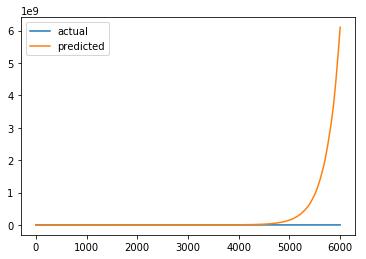

Test RMSE: 1.166


In [37]:
from sklearn.metrics import mean_squared_error
from math import sqrt 

yhat = rnn.predict( 
    [
        X_test_volume,
        X_test_trends,
        X_test_lagged_price,
        X_test_trends_coinbase,
        X_test_trends_blockchain,
        X_test_trends_bubble
    ],
    verbose=0
)

plt.plot(Y_test_price, label='actual')
plt.plot(yhat, label='predicted')
plt.legend()
plt.show();


# invert scaling 
display(yhat)

display(yhat.shape)

# RESHAPE NOT WORKING?!?!?!?!?!?!?
#yhat = np.reshape(yhat,(test_size_index - train_size-data_length, 1 ))# it forecasts the next 10 hours, so just reshape to 1D 
yhat = np.reshape(yhat, (-1,1))

display(yhat.shape)

display(yhat)
yhat_transformed = scalers['Close'].inverse_transform(yhat)  # maybe something with columns again 
display(yhat_transformed)
yhat_inverted = np.exp(np.cumsum(yhat_transformed)) # undo log difference to get original 
display('yhat_inverted', yhat_inverted)

Y_test_price = Y_test_price.reshape((test_size_index - train_size-data_length, 1 ))
Y_test_price_inv = scalers['Close'].inverse_transform(Y_test_price) 
Y_test_price_inv = np.exp(np.cumsum( Y_test_price_inv   ))  
display(Y_test_price_inv)

#Y_test_price_inv = np.exp(np.cumsum(   np.concatenate( ( df['Close'].iloc[0]  ,Y_test_price_inv )  )   ))  # np.concatenate(([x[0]], x_diff))

plt.plot(Y_test_price_inv, label='actual')
plt.plot(yhat_inverted, label='predicted')
plt.legend()
plt.show();

rmse = sqrt(mean_squared_error(Y_test_price_inv[1:], yhat[1:]))
print('Test RMSE: %.3f' % rmse)




